In this notebook we conducted GWR and MGWR regression models on our data for the city of Chicago specifically. 

The models are identical in variables, the only difference is the regression type. Both models utilize the accessibility score of each census tract within the city of Chicago as the dependent variable. Meanwhile the independent variables are the percent white population, median household income, and percent with a bachelors degree or higher in each respective census tract. 

The results from this model are quite impactful, yet the limitations from UChicago utilizing inefficient servers for programming make the results of the MGWR model in particular largely innaccessible. For better visualization of the output of this data, please refer to our poster and/or presentations, since these are the results accessible through software UChicago has chosen not to provide its research assistants, ArcPro. 

In [3]:
import geopandas as gpd
import pandas as pd
#read in for plots
import pyarrow.parquet as pq
#to read vision Providers
import geodatasets
import folium
import numpy as np
pd.set_option('display.max_columns', None)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

In [5]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

In [6]:
import plotly.express as px
import plotly.graph_objects as go

In [7]:
import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: N

In [8]:
import esda
from esda.moran import Moran, Moran_Local

In [9]:
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

In [10]:
from giddy.directional import Rose

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

In [13]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

In [14]:
import warnings
warnings.filterwarnings('ignore') 
import time

In [15]:
#Read in census tract Info and boundaries
censusTract = gpd.read_file("../Geospatial/ILCensusTracts.zip")

In [16]:
censusTract

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,031,510300,17031510300,5103,Census Tract 5103,G5020,S,2958348,0,+41.7157373,-087.5749771,"POLYGON ((-87.58745 41.72327, -87.58699 41.723..."
1,17,031,520100,17031520100,5201,Census Tract 5201,G5020,S,2581898,521681,+41.7211184,-087.5294325,"POLYGON ((-87.54292 41.72391, -87.54276 41.724..."
2,17,097,863006,17097863006,8630.06,Census Tract 8630.06,G5020,S,207264,0,+42.3003410,-087.8538353,"POLYGON ((-87.85621 42.29921, -87.85604 42.299..."
3,17,097,863004,17097863004,8630.04,Census Tract 8630.04,G5020,S,4440910,0,+42.3046642,-087.8642654,"POLYGON ((-87.87635 42.30871, -87.87565 42.308..."
4,17,097,866200,17097866200,8662,Census Tract 8662,G5020,S,32717452,584438,+42.2360556,-087.9107093,"POLYGON ((-87.94467 42.24049, -87.94088 42.240..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,17,199,020801,17199020801,208.01,Census Tract 208.01,G5020,S,153192395,1647960,+37.8133870,-088.8121922,"POLYGON ((-88.90260 37.86239, -88.90172 37.862..."
3261,17,199,021001,17199021001,210.01,Census Tract 210.01,G5020,S,3743510,1762,+37.7427576,-088.9344534,"POLYGON ((-88.94208 37.75568, -88.94123 37.755..."
3262,17,199,021003,17199021003,210.03,Census Tract 210.03,G5020,S,4058483,83663,+37.7435760,-088.9498758,"POLYGON ((-88.95898 37.73663, -88.95898 37.736..."
3263,17,091,011700,17091011700,117,Census Tract 117,G5020,S,2373268,102060,+41.1294653,-087.8735796,"POLYGON ((-87.88768 41.13594, -87.88764 41.136..."


In [17]:
chicago = pd.read_csv('../IL Work/AccessChicago.csv')
#Read in specifically Chicago Info

In [18]:
#Set Chicago GeoID as integer
chicago['GEOID']=chicago['GEOID'].astype(int)

In [19]:
#Set Census Tract GEOID as integer
censusTract['GEOID']=censusTract['GEOID'].astype(int)

In [20]:
#merged Chicago and census tract geometries
mergedTract=pd.merge(chicago, censusTract, how='left', on= "GEOID")

In [21]:
mergedTract

,OID_,STATEFP_x,COUNTYFP_x,TRACTCE_x,GEOID,NAME_x,NAMELSAD_x,MTFCC_x,FUNCSTAT_x,ALAND_x,AWATER_x,INTPTLAT_x,INTPTLON_x,OPTPer1000,Field2,LogDist,Field,HispDoub,BelowPovDo,AgeDoub,PovDoub,GEOID_1,Total_count,Optometry_count,Ophthalmology_count,Others_count,NAMESLAD,TotalPop,WhitePerc,Median_household_income,Mean_household_income,Bach_or_higher_perc,No_high_school_grad_perc,Percent_insured,index,TRACTCE_1,POPULATION_x,Clean_Zip,Full_Address,Optometry,Distances,BlackPerc,AsianPerc,Median_Age,HispPerc,PercVisionDisab,BelowPovertyPerc,Field1,STATEFP_1,COUNTYFP_1,TRACTCE_12,GEOID_12,NAME_1,NAMELSAD_1,MTFCC_1,FUNCSTAT_1,ALAND_1,AWATER_1,INTPTLAT_1,INTPTLON_1,Areas,Score,OtherScore,Area,STATEFP_y,COUNTYFP_y,TRACTCE_y,NAME_y,NAMELSAD_y,MTFCC_y,FUNCSTAT_y,ALAND_y,AWATER_y,INTPTLAT_y,INTPTLON_y,geometry
0,1,17,31,510300,17031510300,5103.0,Census Tract 5103,G5020,S,2958348.0,0.0,41.715737,-87.574977,0.001031,0,7.947989,0,3.1,3.45177,0.0,39.9,1.703151e+10,8,5,3,0,Census Tract 5103,4850,0.87,25805,47094,15.2,20.9,96.7,3133,510300,4850,60619,1401 E 87TH ST CHICAGO IL 60619,True,2829.88,95.38,0.02,35.1,3.1,3.45177,39.9,0,17,31,510300,1.703151e+10,5103.0,Census Tract 5103,G5020,S,2958348,0.0,41.715737,-87.574977,2.958347e+06,22.904143,9.115516,2.958347e+06,17,031,510300,5103,Census Tract 5103,G5020,S,2958348,0,+41.7157373,-087.5749771,"POLYGON ((-87.58745 41.72327, -87.58699 41.723..."
1,2,17,31,520100,17031520100,5201.0,Census Tract 5201,G5020,S,2581898.0,521681.0,41.721118,-87.529432,0.000573,1,7.279586,0,5.6,3.16148,90.4,10.6,1.703152e+10,1,1,0,0,Census Tract 5201,1745,20.97,61875,65211,9.6,41.4,71.6,3138,520100,1745,60617,10527 S AVENUE F CHICAGO IL 60617,True,1450.39,7.79,0.23,31.5,5.6,3.16148,10.6,1,17,31,520100,1.703152e+10,5201.0,Census Tract 5201,G5020,S,2581898,521681.0,41.721118,-87.529432,3.103581e+06,6.260806,3.942275,3.103581e+06,17,031,520100,5201,Census Tract 5201,G5020,S,2581898,521681,+41.7211184,-087.5294325,"POLYGON ((-87.54292 41.72391, -87.54276 41.724..."
2,3,17,31,590700,17031590700,5907.0,Census Tract 5907,G5020,S,869830.0,12614.0,41.826054,-87.662789,0.002643,2,3.691858,0,2.1,1.60335,70.4,16.9,1.703159e+10,8,8,0,0,Census Tract 5907,3027,18.00,70313,83260,24.3,20.7,88.4,3232,590700,3027,60609,3663 S PAULINA ST CHICAGO IL 60609,True,40.12,2.28,20.81,35.8,2.1,1.60335,16.9,5,17,31,590700,1.703159e+10,5907.0,Census Tract 5907,G5020,S,869830,12614.0,41.826054,-87.662789,8.824440e+05,181.131177,34.565437,8.824440e+05,17,031,590700,5907,Census Tract 5907,G5020,S,869830,12614,+41.8260539,-087.6627888,"POLYGON ((-87.67040 41.83045, -87.67015 41.830..."
3,4,17,31,600400,17031600400,6004.0,Census Tract 6004,G5020,S,327229.0,0.0,41.841718,-87.643932,0.043286,3,6.219648,0,3.5,2.70116,3.9,21.0,1.703160e+10,193,186,8,0,Census Tract 6004,4297,24.16,57637,87231,31.6,20.3,88.8,3233,600400,4297,60616,623 W 25TH PL CHICAGO IL 60616,True,502.53,1.07,63.14,42.5,3.5,2.70116,21.0,6,17,31,600400,1.703160e+10,6004.0,Census Tract 6004,G5020,S,327229,0.0,41.841718,-87.643932,3.272316e+05,267.594221,45.653207,3.272316e+05,17,031,600400,6004,Census Tract 6004,G5020,S,327229,0,+41.8417183,-087.6439322,"POLYGON ((-87.64645 41.84533, -87.64621 41.845..."
4,5,17,31,830600,17031830600,8306.0,Census Tract 8306,G5020,S,661394.0,0.0,42.001698,-87.673574,0.001216,4,6.792961,0,1.2,2.95015,31.5,15.9,1.703183e+10,7,6,1,0,Census Tract 8306,4935,37.28,59213,81463,42.0,12.8,81.0,2342,830600,4935,60626,1209 W ARTHUR AVE APT 415 CHICAGO IL 60626,True,891.55,16.47,6.59,32.2,1.2,2.95015,15.9,14,17,31,830600,1.703183e+10,8306.0,Census Tract 8306,G5020,S,661394,0.0,42.001698,-87.673574,6.613918e+05,86.412447,24.087169,6.613918e+05,17,031,830600,8306,Census Tract 8306,G5020,S,661394,0,+42.0016980,-087.6735738,"POLYGON ((-87.68017 42.00521, -87.67972 42.005..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [22]:
#Specify geometry
mergedTract = mergedTract.set_geometry(mergedTract["geometry"])

In [23]:
#Set Dependent variable
y = mergedTract['OtherScore'].values.reshape((-1,1)) # reshape is needed to have column array

In [24]:
#Set independent variables
X = mergedTract[['Median_household_income', 'Bach_or_higher_perc', 'WhitePerc']].values
X.shape

(791, 3)

In [25]:
#Set coordinates
u = mergedTract['INTPTLON_x']
v = mergedTract['INTPTLAT_x']
coords = list(zip(u,v))

In [26]:

%%time
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

CPU times: user 10.9 s, sys: 26.3 s, total: 37.2 s
Wall time: 4.42 s


In [27]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 50.0


In [28]:
#Run GWR regression model
gwr_results = GWR(coords, y, X, gwr_bw).fit()

In [29]:
#View results of GWR
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 791
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         259239.534
Log-likelihood:                                                   -3413.199
AIC:                                                               6834.399
AICc:                                                              6836.475
BIC:                                                             253987.648
R2:                                                                   0.202
Adj. R2:                                                              0.199

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [30]:
#View mean R2
print('Mean R2 =', gwr_results.R2)

Mean R2 = 0.8565051166630853


In [31]:
#View AICc
print('AICc =', gwr_results.aicc)

AICc = 5800.335924870055


In [32]:
#View AIC
print('AIC =', gwr_results.aic)

AIC = 5742.701298789804


In [33]:
#Set local R2 within DF
mergedTract['gwr_R2']=gwr_results.localR2

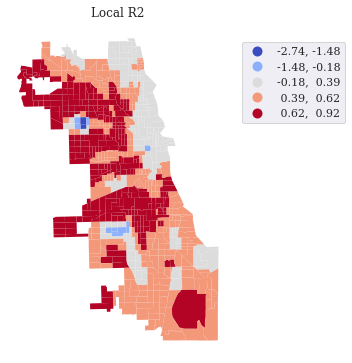

In [34]:
#Plot local R2 to assess model fit and variability
fig, ax = plt.subplots(figsize=(6, 6))
mergedTract.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.55, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [35]:
#Add GWR INT to DF
mergedTract['gwr_intercept'] = gwr_results.params[:,0]

In [36]:
#Add gwr fb to df
mergedTract['gwr_fb']        = gwr_results.params[:,1]

In [37]:
#Add gwr aa to df
mergedTract['gwr_aa']        = gwr_results.params[:,2]

In [38]:
#Add gwr rural to df
mergedTract['gwr_rural']     = gwr_results.params[:,3]

In [39]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

In [40]:
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results.filter_tvals()

In [41]:
Zy = (y - y.mean(axis=0)) / y.std(axis=0)
ZX = (X - X.mean(axis=0)) / X.std(axis=0)

In [ ]:
#Run mgwr model
mgwr_selector = Sel_BW(coords, Zy, ZX, multi=True)
mgwr_bw = mgwr_selector.search()
mgwr_bw

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

In [44]:
#View results of MGWR model
mgwr_results = MGWR(coords, Zy, ZX, mgwr_selector).fit()
mgwr_results.summary()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 791
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            631.147
Log-likelihood:                                                   -1033.092
AIC:                                                               2074.185
AICc:                                                              2076.261
BIC:                                                              -4620.739
R2:                                                                   0.202
Adj. R2:                                                              0.199

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------